In [1]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from io import StringIO
import import_ipynb
from evaluation import to_timestamp, request_influxdb, query_data, histplots, boxplots, lineplots, missing_data, correlation


importing Jupyter notebook from evaluation.ipynb


In [2]:
# Load Tangaras
tangaras = pd.read_csv('../data/tangaras.csv')
tangaras.shape

(22, 7)

In [3]:
# Start Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
start_timestamp = to_timestamp('2023-03-17T00:00:00-05:00')
#start_timestamp = to_timestamp('2023-04-03T00:00:00-05:00')
# End Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
end_timestamp = to_timestamp('2023-03-31T00:00:00-05:00')
#end_timestamp = to_timestamp('2023-04-04T00:00:00-05:00')

print(f'Since: {start_timestamp} Until: {end_timestamp}')


Since: 1679029200000 Until: 1680238800000


In [4]:
# Query Data Sensors
query = query_data(tangaras, start_timestamp, end_timestamp, datatype='tmp')
print(query)

SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0DD66') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0E752') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE1260A') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE94B1A') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE965F2') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DEBD89A') AND time >= 1679029200000ms AND time <= 168

In [5]:
# Get Data Frame Sensors
def df_sensors(tangaras, start_timestamp, end_timestamp):
    # Data Frame Sensors
    df_sensors = []
    # SQL Query Data Sensors
    query = query_data(tangaras, start_timestamp, end_timestamp, datatype='tmp')
    # InfluxDB API REST Request
    influxdb_request = request_influxdb(query)
    #print(influxdb_request)
    #print(influxdb_request.text)

    # Data Frame InfluxDB Sensors
    df_influxdb_sensors = pd.read_csv(StringIO(influxdb_request.text), sep=",", low_memory=False)

    # Remove/Add Columns
    df_influxdb_sensors = df_influxdb_sensors[['time', 'name.1', 'last']]
    df_influxdb_sensors.rename(columns={'time': 'DATETIME', 'name.1': 'MAC', 'last': 'TEMP'}, inplace=True)

    # Truncate Response
    for index, row in tangaras.iterrows():
        df_sensor = df_influxdb_sensors.loc[df_influxdb_sensors['MAC'] == row['MAC']].reset_index(drop=True)[['DATETIME', 'TEMP']] # Warning
        if not df_sensor.empty:
            df_sensor.rename(columns={'TEMP': row['ID']}, inplace=True)
            df_sensor.set_index('DATETIME', inplace=True)
            df_sensors.append(df_sensor)
    
    df_sensors = df_sensors[0].join(df_sensors[1:]).reset_index()

    # Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
    tz = timezone(timedelta(hours=-5))
    df_sensors['DATETIME'] = df_sensors['DATETIME'].apply(lambda x: datetime.fromtimestamp(int(x) / 1000, tz=tz).isoformat())

    df_sensors[df_sensors.columns.to_list()[1:]] = df_sensors[df_sensors.columns.to_list()[1:]].astype('float64')
    
    return df_sensors


In [6]:
# Data Frame Sensors
temp_raw = df_sensors(tangaras, start_timestamp, end_timestamp)
temp_raw.head()

,DATETIME,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
0,2023-03-17T18:49:30-05:00,0.0,21.73,NaN,21.74,NaN,20.87,21.61,NaN,NaN,...,29.74,25.68,28.37,29.26,NaN,22.64,20.75,27.9,30.38,NaN
1,2023-03-17T18:50:00-05:00,0.0,21.73,NaN,21.76,NaN,20.88,21.61,NaN,30.92,...,29.74,25.78,28.29,29.26,NaN,22.63,20.79,27.8,30.41,NaN
2,2023-03-17T18:51:00-05:00,0.0,21.78,NaN,21.81,NaN,20.84,21.64,NaN,30.90,...,29.72,25.81,28.25,29.25,NaN,22.65,20.78,27.8,30.32,NaN
3,2023-03-17T18:51:30-05:00,0.0,21.81,NaN,21.80,NaN,20.87,21.65,NaN,30.88,...,NaN,25.75,28.31,29.27,NaN,22.71,20.79,27.8,30.34,NaN
4,2023-03-17T18:52:00-05:00,0.0,21.81,NaN,21.83,NaN,20.88,21.66,NaN,30.90,...,29.73,25.75,28.31,29.29,NaN,22.72,20.79,27.8,30.32,NaN


# Descriptive Statistics

In [7]:
# Describe Data
temp_raw.describe()

,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,TANGARA_1A1E,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,27537.0,27066.000000,7384.000000,26889.000000,8035.000000,26887.000000,26595.000000,1090.000000,26758.000000,25374.000000,...,25781.000000,27407.000000,26121.000000,26177.000000,16471.000000,26939.000000,26773.000000,27272.000000,26978.000000,26368.000000
mean,0.0,23.924324,24.302713,24.636936,24.221360,23.343491,25.155562,29.886248,29.944136,29.062267,...,28.898538,26.548668,29.863124,28.773777,28.182537,25.576248,23.099036,27.843627,29.423351,28.747045
std,0.0,2.937078,2.520573,3.417796,2.351595,3.015827,3.590551,2.503423,1.858596,4.823214,...,4.424837,2.187691,2.356928,3.813303,5.083831,3.560885,3.111692,3.757248,2.836596,3.235813
min,0.0,19.660000,19.050000,19.510000,18.900000,18.070000,19.350000,24.240000,26.470000,20.900000,...,20.340000,22.710000,25.710000,23.420000,20.610000,20.240000,18.520000,21.300000,22.510000,23.790000
25%,0.0,21.710000,22.170000,21.910000,22.400000,20.960000,22.160000,28.030000,28.410000,24.900000,...,24.900000,24.990000,28.210000,25.330000,23.570000,22.830000,20.760000,24.600000,26.820000,25.780000
50%,0.0,22.970000,23.570000,23.370000,23.510000,22.460000,24.120000,29.100000,29.670000,27.470000,...,27.830000,26.260000,29.150000,27.720000,26.410000,24.300000,22.080000,26.900000,29.110000,28.140000
75%,0.0,26.210000,26.370000,27.260000,26.210000,25.640000,28.000000,32.280000,31.310000,32.860000,...,33.050000,27.630000,31.050000,31.920000,32.620000,28.240000,25.450000,30.600000,31.730000,31.240000
max,0.0,32.720000,30.040000,35.040000,29.960000,32.550000,35.850000,35.660000,34.350000,42.040000,...,38.810000,36.810000,37.690000,38.300000,40.160000,36.990000,32.940000,37.100000,35.590000,36.710000


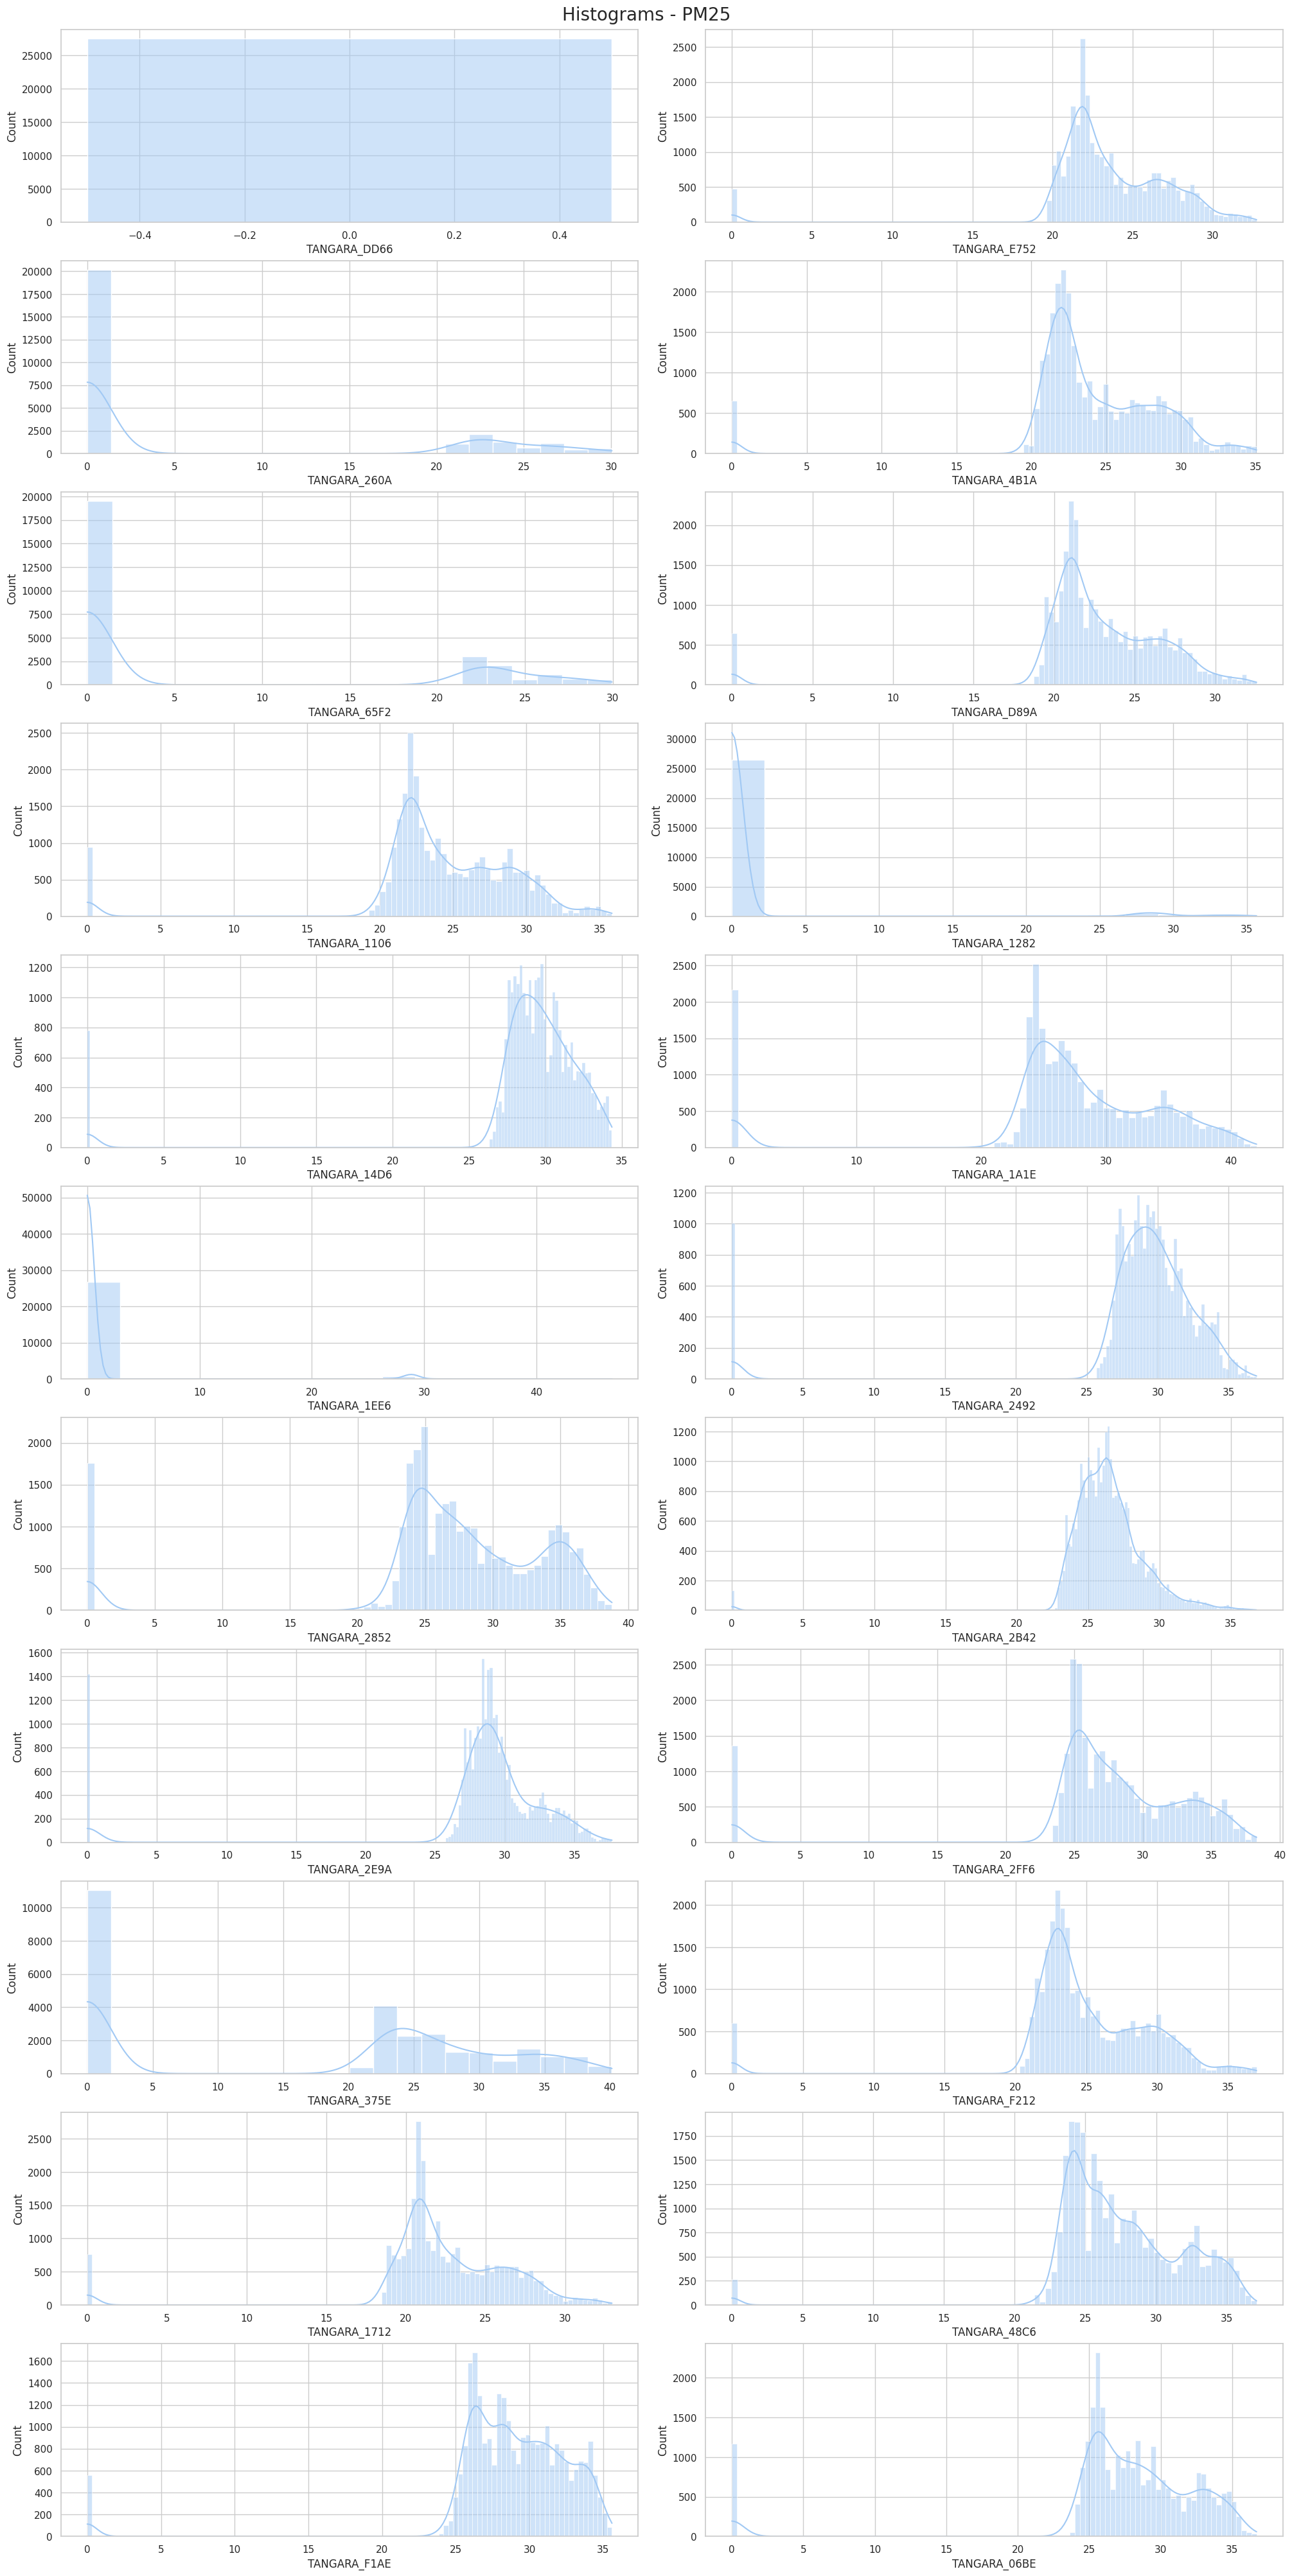

In [8]:
# Plot Temperature Histograms
histplots(temp_raw)

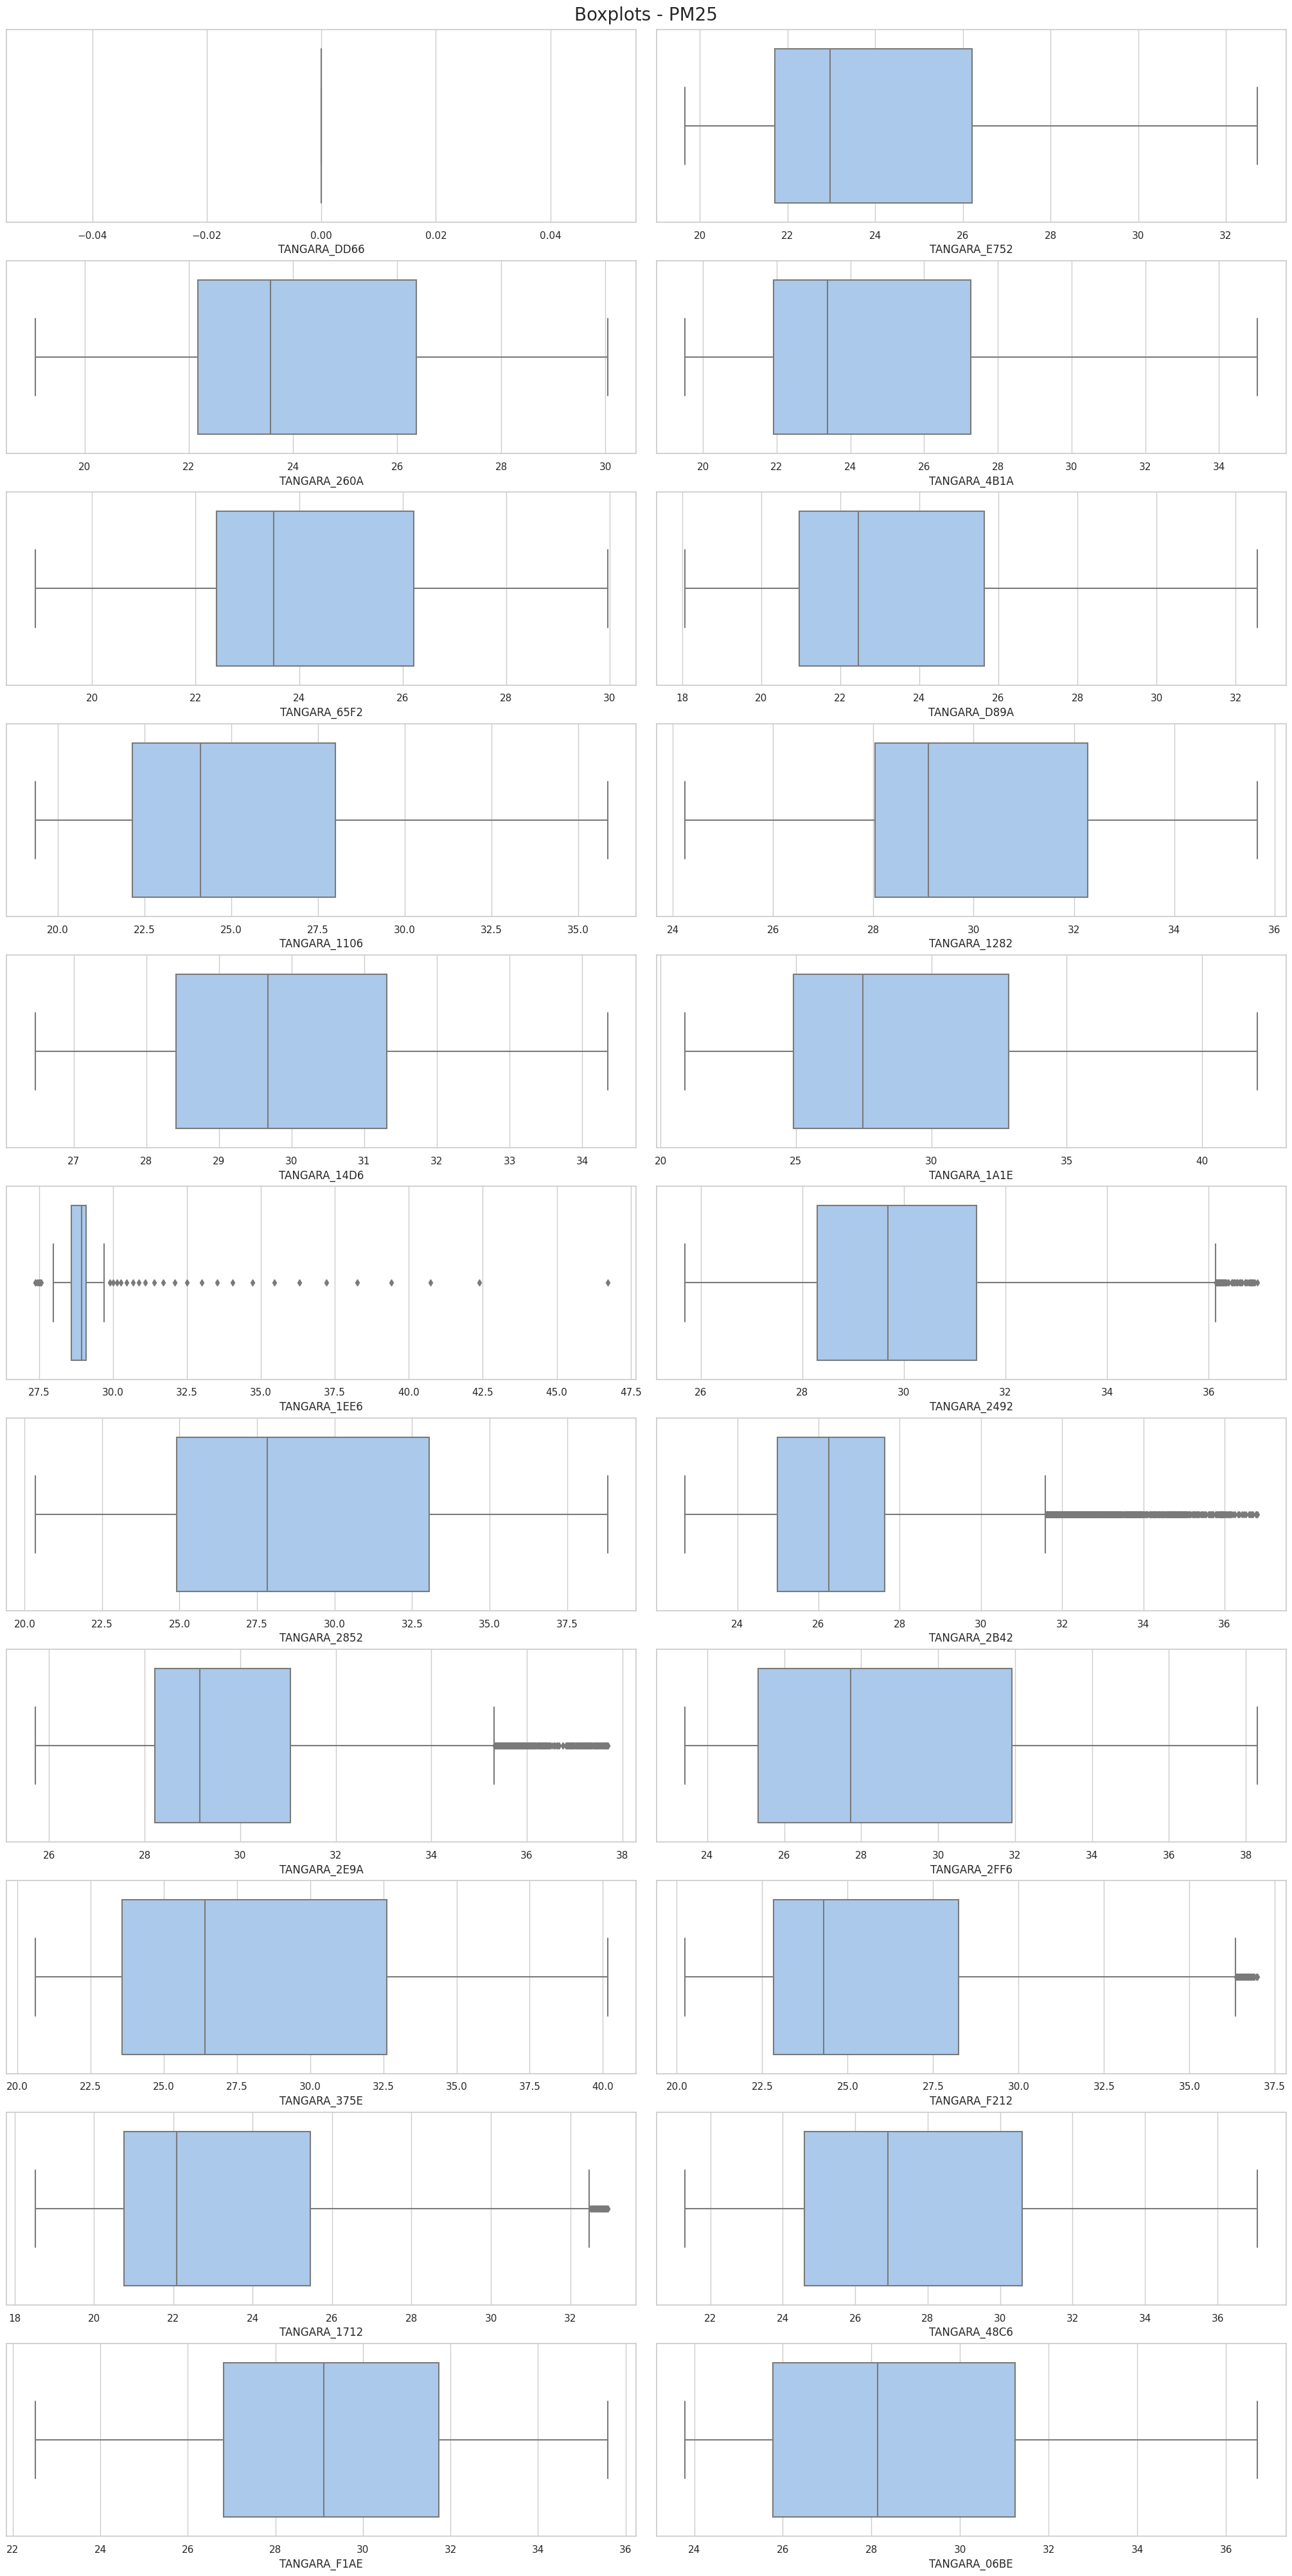

In [9]:
# Plot Temperature Boxplots
boxplots(temp_raw)

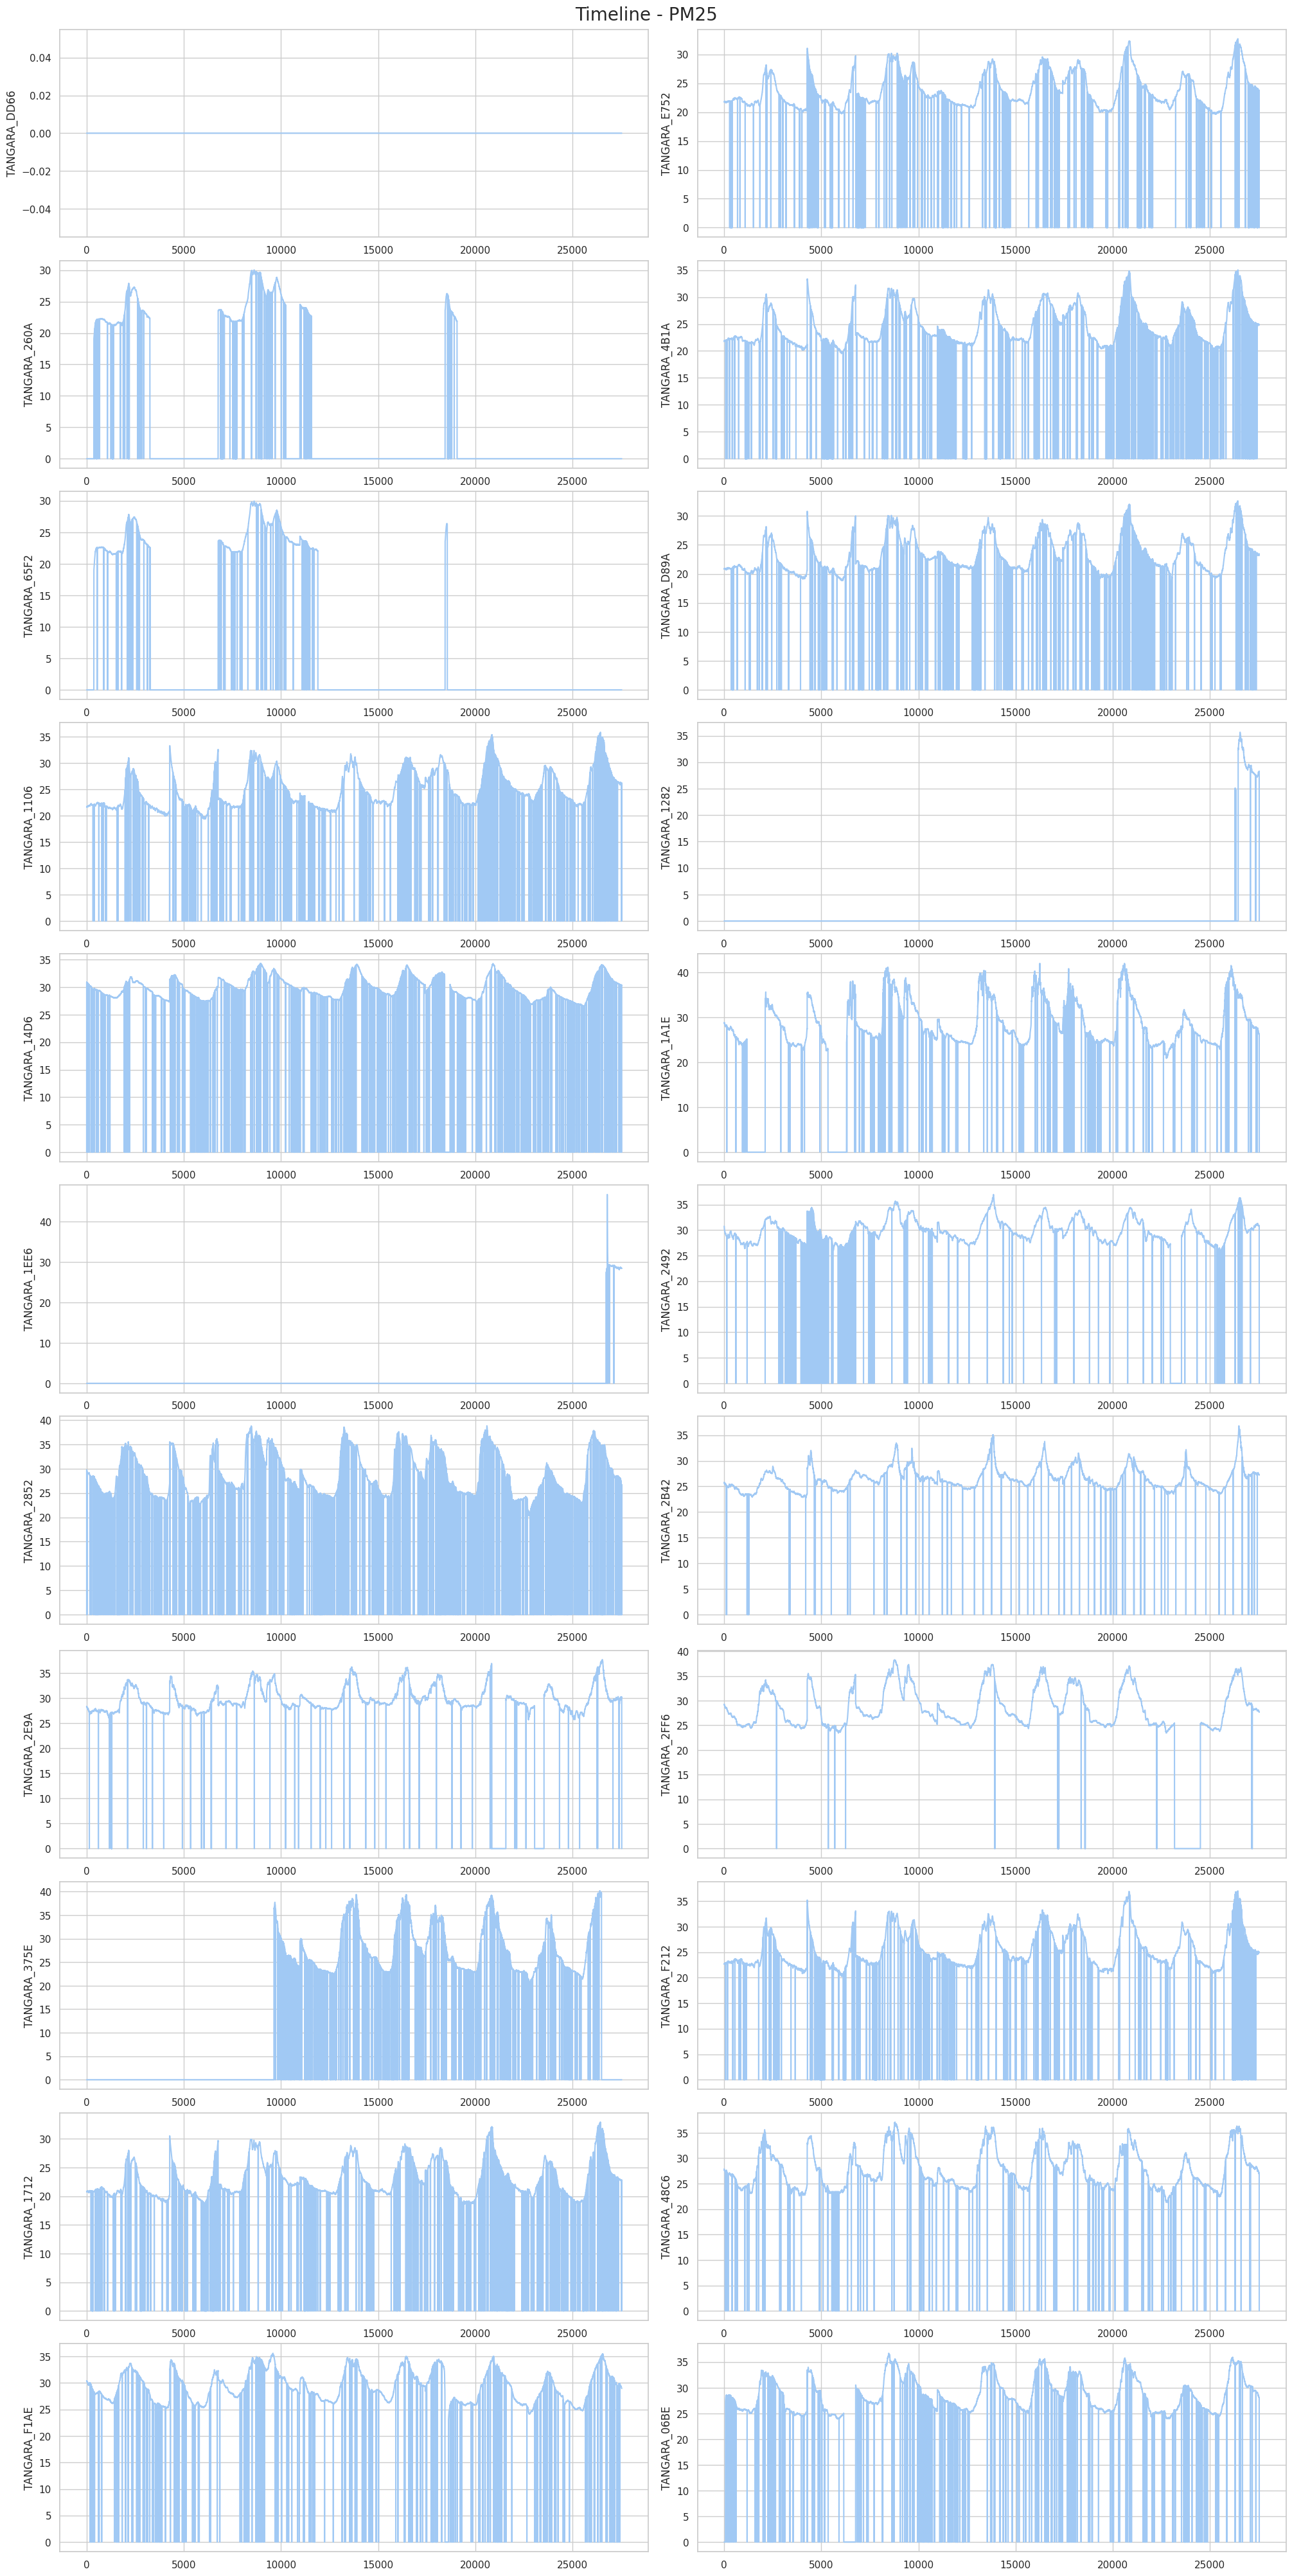

In [10]:
# Plot Temperature Lineplots
lineplots(temp_raw)

In [11]:
# Missing Data Sensors
threshold = 85
to_be_checked = missing_data(temp_raw, threshold)

print(f'Threshold: {threshold}%')
print(f'Total Sensors: {len(temp_raw.columns[1:])}')
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked

Threshold: 85%
Total Sensors: 22
To Be Checked: 5


[{'ID': 'TANGARA_260A', 'Data': '27%', 'Missing': '73%'},
 {'ID': 'TANGARA_65F2', 'Data': '29%', 'Missing': '71%'},
 {'ID': 'TANGARA_1282', 'Data': '4%', 'Missing': '96%'},
 {'ID': 'TANGARA_1EE6', 'Data': '3%', 'Missing': '97%'},
 {'ID': 'TANGARA_375E', 'Data': '60%', 'Missing': '40%'}]

In [12]:
# Sensors to evaluate by Pearson correlation coefficient
sensors_to_evaluate = temp_raw[['DATETIME', 'TANGARA_DD66', 'TANGARA_E752', 'TANGARA_4B1A', 'TANGARA_D89A', 'TANGARA_1106', 'TANGARA_F212', 'TANGARA_1712']]

# Pearson correlation coefficient
threshold = 0.7
to_be_checked = correlation(sensors_to_evaluate, 'TANGARA_D89A', threshold)

# Correlation Sensors
print(f'Threshold: {threshold}')
print(f'Total Sensors: {len(sensors_to_evaluate.columns[1:])}')
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked


Threshold: 0.7
Total Sensors: 7
To Be Checked: 1


[{'Reference': {'ID': 'TANGARA_D89A', 'Data': 38061, 'Freq': <30 * Seconds>},
  'Target': {'ID': 'TANGARA_DD66', 'Data': 38061, 'Freq': <30 * Seconds>},
  'Correlation': 0}]

In [13]:
# Save Temperature raw data into CSV file
temp_raw.to_csv('../data/temp_raw.csv', index=False)